In [1]:
# Run once if not in Colab
!pip install huggingface_hub
!pip install transformers datasets tokenizers seqeval -q evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-

In [18]:
from utilities_2 import preprocess, create_model_init, get_compute_metrics, concatenate_splits, fine_tuning_training_on_single_corpus
from huggingface_hub import HfApi
import os
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    AutoConfig,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification,
    pipeline
)
import numpy as np
import pandas as pd
from seqeval.metrics import f1_score
from transformers import EvalPrediction

from transformers import TrainingArguments
from datasets import get_dataset_config_names
from datasets import load_dataset

from transformers import DataCollatorForTokenClassification

from collections import defaultdict

from collections import Counter

from transformers import Trainer

import torch

from seqeval.metrics import classification_report

In [4]:
import gdown
os.makedirs("data", exist_ok=True)
# Create the directories if they don't exist
directories = ["data/test", "data/train", "data/val"]

for directory in directories:
  os.makedirs(directory, exist_ok=True)
test=["1oLOiziBhBl5nIcSfzAZw9YNmahbppEAE", "1OU5YvvBHsASiAE61rTlQEeVyFaWtnsjI"]
train=["11mSNDRuXCb78ay2x5sQYwCb9_ipeXZwh","1gzbYd7ofSAV4agIP3GHeepO09j2j7c8Q"]
val=["1uRy5fIWA7xLr2-dROo119fsq1yyQMRZ_", "12YJ5hY91psICvCItLmKHprVC89bcbBUO"]
file_names=["lemmatized_sl.txt", "lemmatized_uk.txt"]
for url, output in zip(test, file_names):
    gdown.download("https://drive.google.com/uc?id="+ url, "data/test/" + output)
for url, output in zip(train, file_names):
    gdown.download("https://drive.google.com/uc?id="+url, "data/train/" + output)
for url, output in zip(val, file_names):
    gdown.download("https://drive.google.com/uc?id="+url, "data/val/" + output)

Downloading...
From: https://drive.google.com/uc?id=1oLOiziBhBl5nIcSfzAZw9YNmahbppEAE
To: /content/data/test/lemmatized_sl.txt
100%|██████████| 1.89M/1.89M [00:00<00:00, 220MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OU5YvvBHsASiAE61rTlQEeVyFaWtnsjI
To: /content/data/test/lemmatized_uk.txt
100%|██████████| 880k/880k [00:00<00:00, 137MB/s]
Downloading...
From: https://drive.google.com/uc?id=11mSNDRuXCb78ay2x5sQYwCb9_ipeXZwh
To: /content/data/train/lemmatized_sl.txt
100%|██████████| 3.20M/3.20M [00:00<00:00, 185MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gzbYd7ofSAV4agIP3GHeepO09j2j7c8Q
To: /content/data/train/lemmatized_uk.txt
100%|██████████| 1.38M/1.38M [00:00<00:00, 72.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1uRy5fIWA7xLr2-dROo119fsq1yyQMRZ_
To: /content/data/val/lemmatized_sl.txt
100%|██████████| 2.19M/2.19M [00:00<00:00, 34.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=12YJ5hY91psICvCItLmKHprVC89bcbBUO
To: /content/data/

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CUDA not available. Using CPU.")

CUDA is available. Using GPU: Tesla T4


## Test small Ukranian models

In [6]:
model_name="xlm-roberta-large"
language_code="uk"

In [7]:
try:
    data = preprocess(language_code=language_code, model_name=model_name, train="all")
    tokenized_dataset, label_list, label2id, id2label, tokenizer = data[0], data[1], data[2], data[3], data[4]
    print("Sample from training data:")
    print(tokenized_dataset["train"][0])
    num_labels = len(label_list)
except NameError:
    print("Error: The 'preprocess' function is not defined.")
    print("Please ensure 'utilities.py' is in the same directory or accessible in your Python path,")
    print("and that it contains the 'preprocess' function.")
    # Example placeholder data if preprocess fails - replace with actual loading if needed
    tokenized_dataset = None # Set to None or load dummy data
    label_list = ["O", "B-PER", "I-PER", "B-ORG", "I-ORG", "B-LOC", "I-LOC"] # Example labels
    label2id = {label: i for i, label in enumerate(label_list)}
    id2label = {i: label for i, label in enumerate(label_list)}
    num_labels = len(label_list)
    tokenizer = AutoTokenizer.from_pretrained(model_name) # Load tokenizer separately if needed
    print("\nWARNING: Using placeholder data because 'preprocess' failed.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/2211 [00:00<?, ? examples/s]

Map:   0%|          | 0/1850 [00:00<?, ? examples/s]

Map:   0%|          | 0/1493 [00:00<?, ? examples/s]

Sample from training data:
{'input_ids': [0, 174222, 229107, 148645, 55782, 92293, 415, 21726, 3494, 829, 22011, 591, 440, 1882, 41099, 6, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': [-100, 1, 10, 10, -100, 10, -100, 10, -100, 10, -100, 10, 10, -100, -100, 10, -100, -100, -100, -100, -100, -1

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2211
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1850
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1493
    })
})

In [8]:
model_init=create_model_init(model_name=model_name, data=data, device=device)
compute_metrics=get_compute_metrics(id2label=id2label)
data_collator = DataCollatorForTokenClassification(tokenizer)

In [9]:
training_args = TrainingArguments(
    output_dir="dump_this", log_level="error", num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False, push_to_hub=False)

In [10]:
metrics_df = pd.DataFrame(columns=["num_samples", "f1_score"])
results = []
for num_samples in [250, 500, 1000, 2000]:
    result = fine_tuning_training_on_single_corpus(
        dataset=tokenized_dataset,
        num_samples=num_samples,
        model_init=model_init,
        training_args=training_args,
        data_collator=data_collator,
        xlmr_tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )
    results.append(result)

metrics_df = pd.concat([metrics_df, pd.DataFrame(results)], ignore_index=True)

/content/utilities_2.py:417: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mihaelstoyanov (mihaelstoyanov-it-universitetet-i-k-benhavn) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/content/utilities_2.py:417: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,


Step,Training Loss


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/content/utilities_2.py:417: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,


Step,Training Loss


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/content/utilities_2.py:417: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,


Step,Training Loss


ValueError: Must pass 2-d input. shape=(4, 1, 2)

In [11]:
print(results)

[   num_samples  f1_score
0          250  0.649947,    num_samples  f1_score
0          500  0.747511,    num_samples  f1_score
0         1000  0.790459,    num_samples  f1_score
0         2000  0.809912]


In [13]:
metrics_df = pd.concat(results, ignore_index=True)
metrics_df

,num_samples,f1_score
0,250,0.649947
1,500,0.747511
2,1000,0.790459
3,2000,0.809912


In [14]:
bg_score={"uk": 0.7736860922416875, "sl": 0.892269436114971}
ru_score={"uk": 0.8250615980288631, "sl": 0.8609369236444115}
bg_ru_score={"uk": 0.8111618111618112, "sl": 0.8961415508140659}

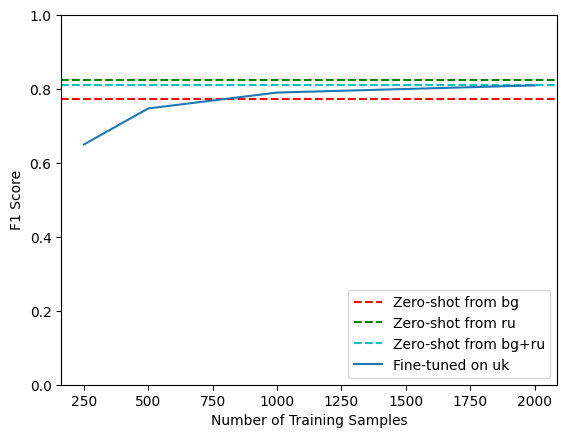

In [19]:
fig, ax = plt.subplots()
ax.axhline(bg_score["uk"], ls="--", color="r")
ax.axhline(ru_score["uk"], ls="--", color="g")
ax.axhline(bg_ru_score["uk"], ls="--", color="c")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from bg", "Zero-shot from ru", "Zero-shot from bg+ru", "Fine-tuned on uk"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.savefig("ukrainian_plot.png")
plt.show()

In [20]:
language_code="sl"
tokenized_dataset=preprocess(language_code=language_code, model_name=model_name, train="all")[0]

Map:   0%|          | 0/7512 [00:00<?, ? examples/s]

Map:   0%|          | 0/5186 [00:00<?, ? examples/s]

Map:   0%|          | 0/4312 [00:00<?, ? examples/s]

In [ ]:
metrics_df = pd.DataFrame(columns=["num_samples", "f1_score"])
results1 = []
for num_samples in [100]:
    result = fine_tuning_training_on_single_corpus(
        dataset=tokenized_dataset,
        num_samples=num_samples,
        model_init=model_init,
        training_args=training_args,
        data_collator=data_collator,
        xlmr_tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )
    results1.append(result)

print(results1)

/content/utilities_2.py:417: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,


Step,Training Loss


In [23]:
results

[   num_samples  f1_score
 0          250  0.525966,
    num_samples  f1_score
 0          500  0.814847,
    num_samples  f1_score
 0         1000       0.0,
    num_samples  f1_score
 0         2000   0.85772]

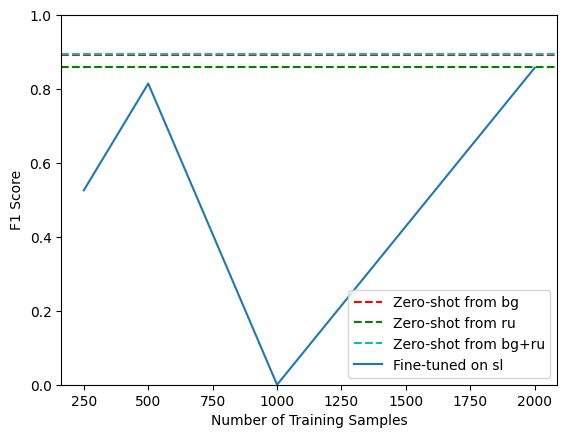

In [22]:
metrics_df = pd.concat(results, ignore_index=True)
fig, ax = plt.subplots()
ax.axhline(bg_score["sl"], ls="--", color="r")
ax.axhline(ru_score["sl"], ls="--", color="g")
ax.axhline(bg_ru_score["sl"], ls="--", color="c")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from bg", "Zero-shot from ru", "Zero-shot from bg+ru", "Fine-tuned on sl"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.savefig("slovenian_plot.png")
plt.show()